1.0 Import Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import re
from datetime import datetime
from google.colab import files
from scipy.stats import norm
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


1.1 Data Collection

In [ ]:
# List of stocks to fetch options data
stocks = [
    "AAPL", "MSFT", "AMZN", "GOOG", "TSLA", "NFLX", "NVDA", "META", "ORCL", "IBM",
    "INTC", "AMD", "QCOM", "ADBE", "CSCO", "CRM", "PYPL", "SAP", "UBER", "LYFT",
    "PEP", "COST", "AVGO", "INTU", "TXN", "TMUS", "GILD", "CHTR", "AMGN", "ISRG",
    "BKNG", "ADP", "MRVL", "WDAY", "SNPS", "PANW", "LRCX", "REGN", "MU", "KLAC",
    "ASML", "ZS", "TEAM", "ZM", "DOCU", "OKTA", "CRWD", "SHOP", "DDOG", "MDB"
]

excluded_stocks = []

# Fetch options data
def fetch_options_data(stock):
    print(f"\nFetching options data for {stock}...")
    ticker = yf.Ticker(stock)
    try:
        expiration_dates = ticker.options
        if not expiration_dates:
            print(f"No expiration dates available for {stock}. Skipping.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Failed to fetch expiration dates for {stock}: {e}")
        return pd.DataFrame()

    all_data = []
    for exp_date in expiration_dates:
        try:
            options_chain = ticker.option_chain(exp_date)

            # Fetch calls
            calls = options_chain.calls
            calls['option_type'] = 'call'  # Label calls
            calls['expiration_date'] = exp_date
            calls['stock'] = stock

            # Fetch puts
            puts = options_chain.puts
            puts['option_type'] = 'put'  # Label puts
            puts['expiration_date'] = exp_date
            puts['stock'] = stock

            # Combine calls and puts
            all_data.append(pd.concat([calls, puts], ignore_index=True))
            print(f"  - Fetched data for expiration date: {exp_date}")
        except Exception as e:
            print(f"  - Failed to fetch data for expiration date {exp_date}: {e}")
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print(f"No data found for {stock}.")
        return pd.DataFrame()

# Fetch stock price
def fetch_stock_price(stock):
    print(f"  - Fetching stock price for {stock}...")
    ticker = yf.Ticker(stock)
    try:
        stock_price = ticker.history(period="1d")['Close'].iloc[-1]
        print(f"    Stock Price: {stock_price:.2f}")
        return stock_price
    except Exception as e:
        print(f"    Failed to fetch stock price for {stock}: {e}")
        return np.nan

# Retry mechanism
def fetch_with_retries(stock, retries=3):
    print(f"\n=== Fetching Data for {stock} with Retry Mechanism ===")
    for attempt in range(retries):
        try:
            print(f"  Attempt {attempt + 1} of {retries}...")
            data = fetch_options_data(stock)
            if not data.empty:
                stock_price = fetch_stock_price(stock)
                if not np.isnan(stock_price):
                    data['stock_price'] = stock_price
                    print(f"  Successfully fetched data for {stock}.")
                    return data
                else:
                    print(f"  Skipping {stock} due to missing stock price.")
        except Exception as e:
            print(f"  Error during attempt {attempt + 1}: {e}")
    print(f"Failed to fetch data for {stock} after {retries} attempts.")
    return pd.DataFrame()

# Fetch data for all stocks
print("\n=== Starting Data Fetch for All Stocks ===")
all_options_data = []
for stock in stocks:
    data = fetch_with_retries(stock)
    if not data.empty:
        all_options_data.append(data)
    else:
        excluded_stocks.append(stock)

# Combine results
if all_options_data:
    options_data = pd.concat(all_options_data, ignore_index=True)
    print(f"\n=== Data Fetch Complete ===")
    print(f"  Total Data Points Collected: {options_data.shape[0]}")
    print(f"  Stocks Excluded: {len(excluded_stocks)}")
    if excluded_stocks:
        print(f"    Excluded Stocks: {', '.join(excluded_stocks)}")
else:
    print("\nNo data fetched!")



=== Starting Data Fetch for All Stocks ===

=== Fetching Data for AAPL with Retry Mechanism ===
  Attempt 1 of 3...

Fetching options data for AAPL...
  - Fetched data for expiration date: 2024-11-29
  - Fetched data for expiration date: 2024-12-06
  - Fetched data for expiration date: 2024-12-13
  - Fetched data for expiration date: 2024-12-20
  - Fetched data for expiration date: 2024-12-27
  - Fetched data for expiration date: 2025-01-03
  - Fetched data for expiration date: 2025-01-17
  - Fetched data for expiration date: 2025-02-21
  - Fetched data for expiration date: 2025-03-21
  - Fetched data for expiration date: 2025-04-17
  - Fetched data for expiration date: 2025-06-20
  - Fetched data for expiration date: 2025-07-18
  - Fetched data for expiration date: 2025-08-15
  - Fetched data for expiration date: 2025-09-19
  - Fetched data for expiration date: 2025-12-19
  - Fetched data for expiration date: 2026-01-16
  - Fetched data for expiration date: 2026-06-18
  - Fetched dat

1.2.1 Exploratory Data Analysis (EDA): Summary Statistics for Parameters

In [ ]:
# Full column list and data types
print("All Columns and Their Data Types:")
print(options_data.dtypes)

# Summary of all columns (including non-numeric)
print("\nSummary of All Columns:")
print(options_data.describe(include='all'))


All Columns and Their Data Types:
contractSymbol                    object
lastTradeDate        datetime64[ns, UTC]
strike                           float64
lastPrice                        float64
bid                              float64
ask                              float64
change                           float64
percentChange                    float64
volume                           float64
openInterest                     float64
impliedVolatility                float64
inTheMoney                        object
contractSize                      object
currency                          object
option_type                       object
expiration_date                   object
stock                             object
stock_price                      float64
dtype: object

Summary of All Columns:
             contractSymbol                        lastTradeDate  \
count                 79853                                79853   
unique                79853                          

1.2.1 Exploratory Data Analysis (EDA): Numerical Parameter Visualization using Histogram

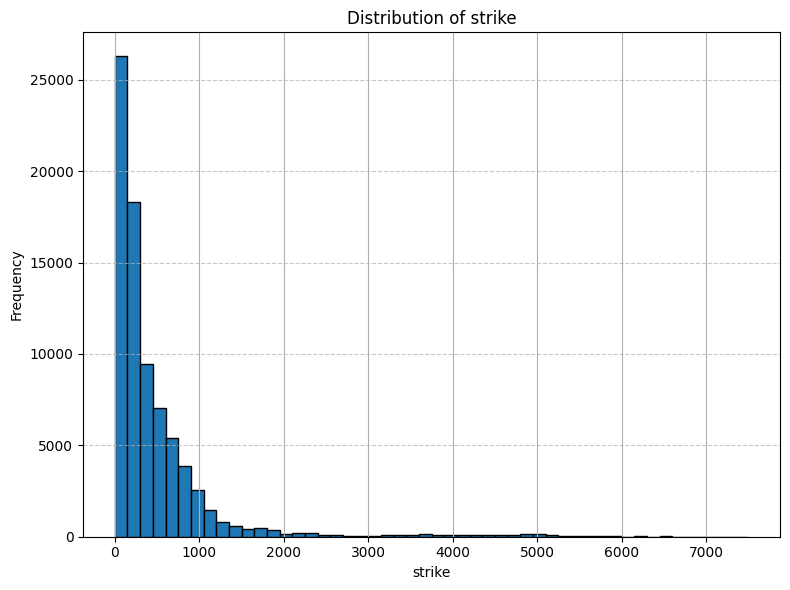

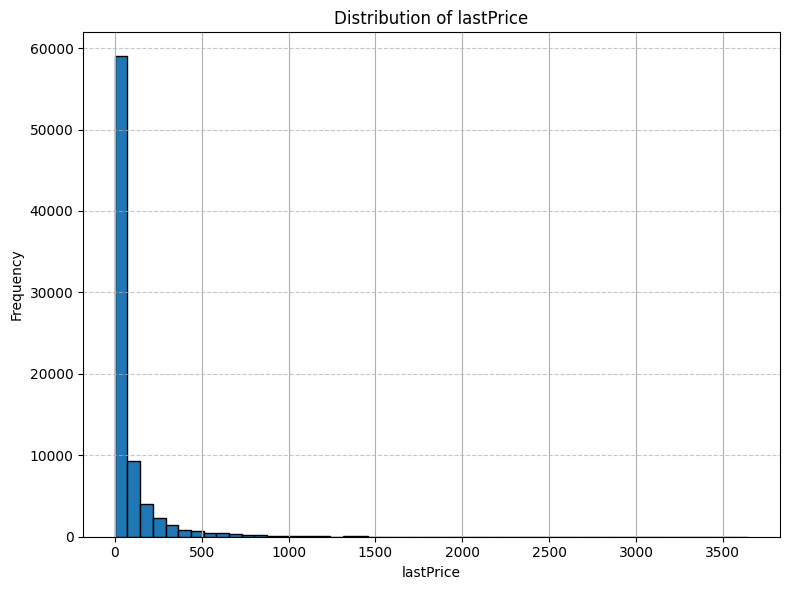

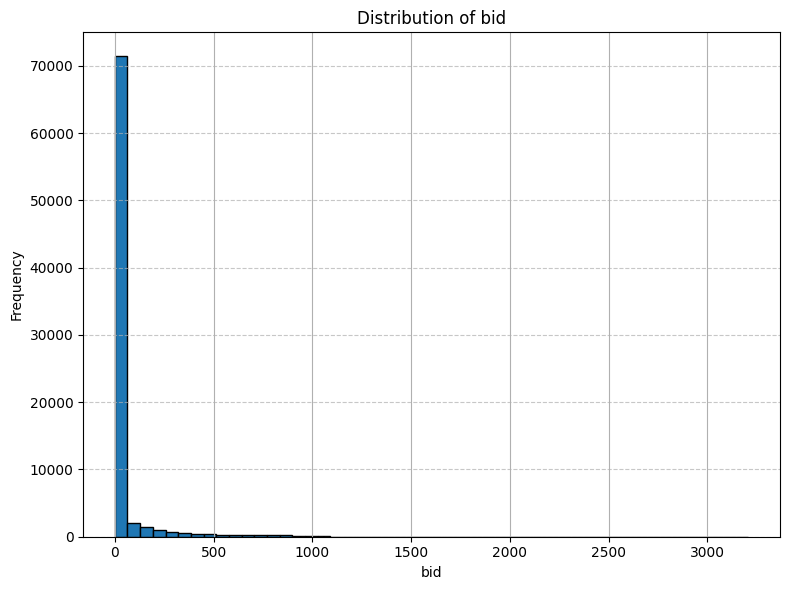

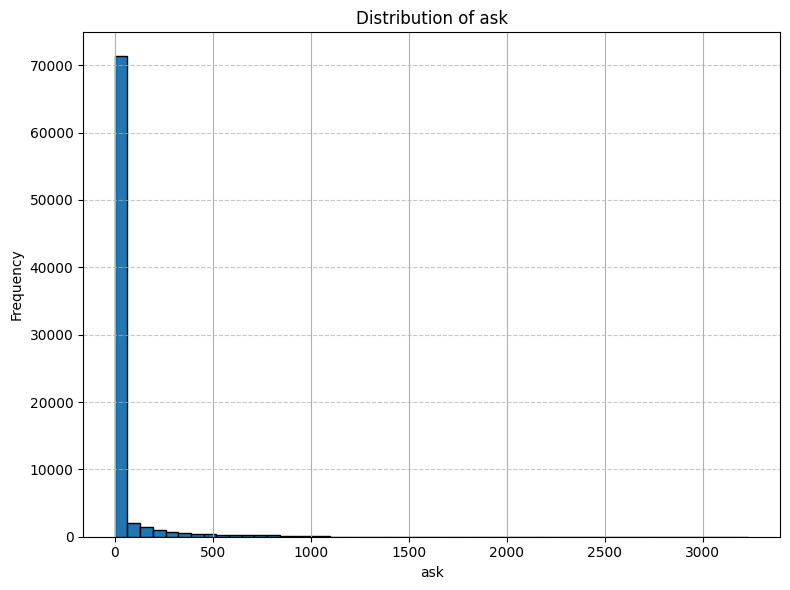

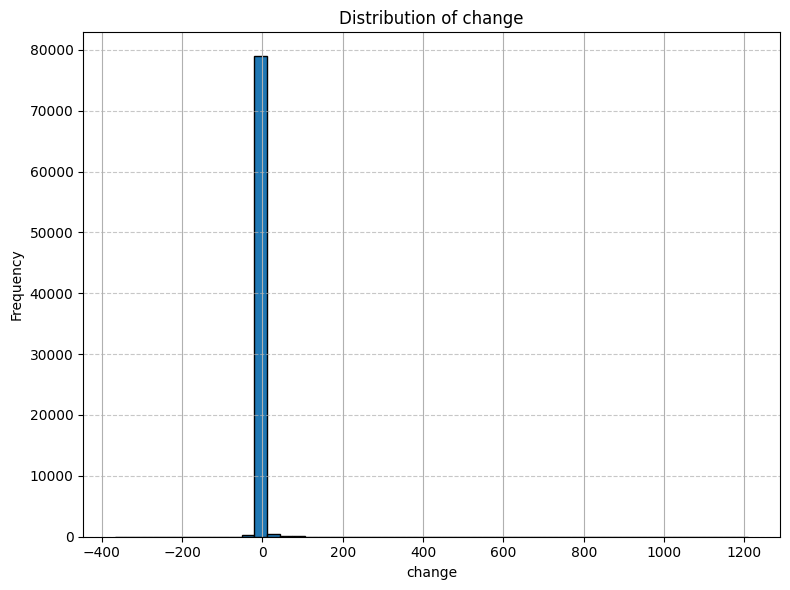

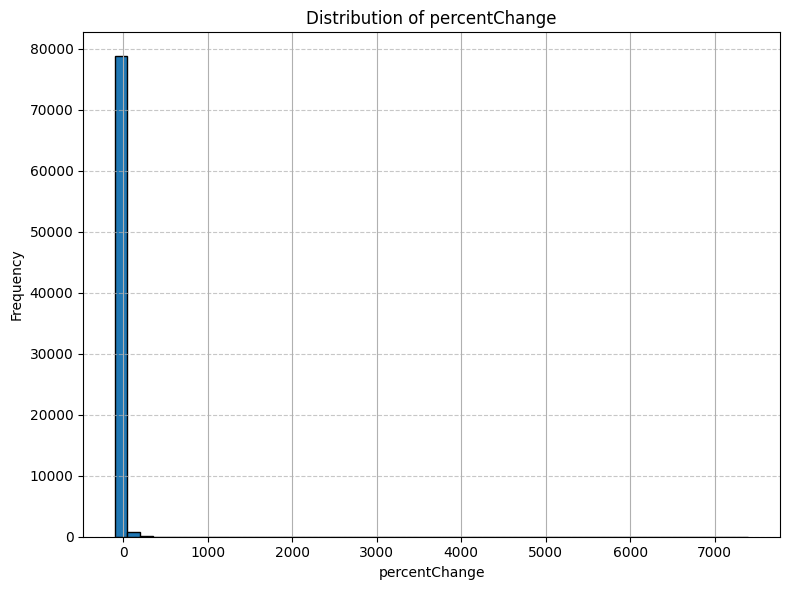

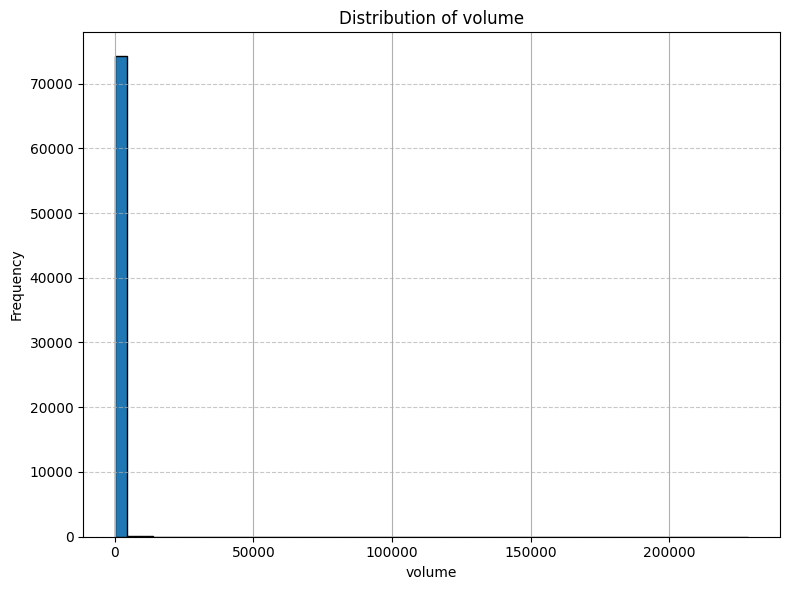

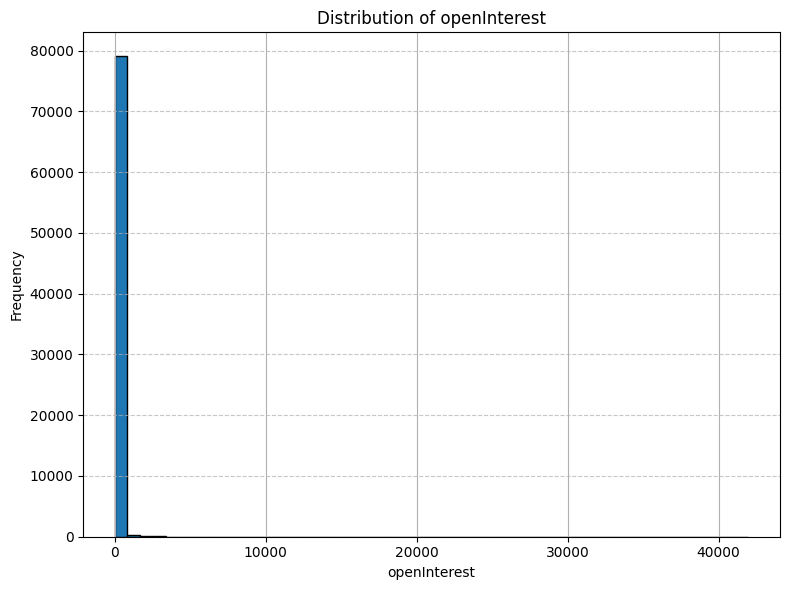

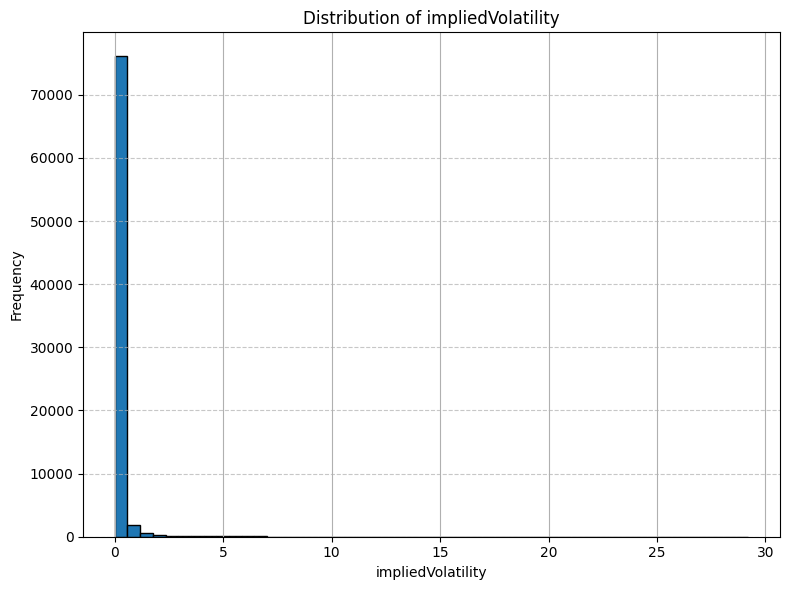

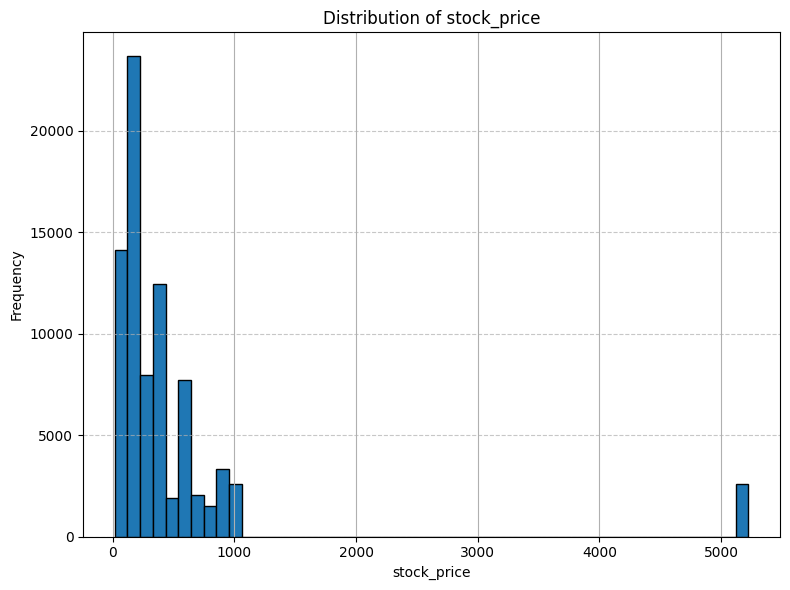

In [ ]:
# List of parameters to visualize
columns_to_visualize = options_data.select_dtypes(include=['float64', 'int64']).columns

# Iterate through each column and plot its histogram
for column in columns_to_visualize:
    plt.figure(figsize=(8, 6))
    options_data[column].dropna().hist(bins=50, edgecolor='black')  # Drop NaNs to avoid errors
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


1.3.1 Data Inspection

In [ ]:
# Check the overall structure of the dataset
print("Dataset Overview:")
print(options_data.info())

# Display the first few rows of the dataset
print("\nFirst Five Rows of the Dataset:")
print(options_data.head())

# Check for missing values
print("\nMissing Values in Each Column:")
missing_values = options_data.isnull().sum()
print(missing_values)

# Check if there are any completely empty rows
empty_rows = options_data.isnull().all(axis=1).sum()
print(f"\nNumber of Completely Empty Rows: {empty_rows}")

# Display rows with missing values if any
if missing_values.any():
    print("\nSample Rows with Missing Values:")
    print(options_data[options_data.isnull().any(axis=1)].head())
else:
    print("\nNo Missing Values in the Dataset.")


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     79853 non-null  object             
 1   lastTradeDate      79853 non-null  datetime64[ns, UTC]
 2   strike             79853 non-null  float64            
 3   lastPrice          79853 non-null  float64            
 4   bid                79601 non-null  float64            
 5   ask                79603 non-null  float64            
 6   change             79853 non-null  float64            
 7   percentChange      79753 non-null  float64            
 8   volume             74546 non-null  float64            
 9   openInterest       79578 non-null  float64            
 10  impliedVolatility  79853 non-null  float64            
 11  inTheMoney         79853 non-null  object             
 12  contractSize       79853 non

1.3.2 Data Cleaning

In [ ]:
# Drop rows with missing values
options_data = options_data.dropna()

# Verify the dataset after cleaning
print("Dataset after removing rows with missing values:")
print(f"Number of rows: {len(options_data)}")
print(f"Number of columns: {len(options_data.columns)}")

# Check for any remaining missing values
print("\nMissing Values in Each Column After Cleaning:")
print(options_data.isnull().sum())

# Display the first few rows of the cleaned dataset
print("\nFirst Five Rows of the Cleaned Dataset:")
print(options_data.head())


Dataset after removing rows with missing values:
Number of rows: 74492
Number of columns: 18

Missing Values in Each Column After Cleaning:
contractSymbol       0
lastTradeDate        0
strike               0
lastPrice            0
bid                  0
ask                  0
change               0
percentChange        0
volume               0
openInterest         0
impliedVolatility    0
inTheMoney           0
contractSize         0
currency             0
option_type          0
expiration_date      0
stock                0
stock_price          0
dtype: int64

First Five Rows of the Cleaned Dataset:
        contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  AAPL241129C00100000 2024-11-26 15:03:46+00:00   100.0     134.60  0.0  0.0   
1  AAPL241129C00115000 2024-11-07 16:47:03+00:00   115.0     111.68  0.0  0.0   
2  AAPL241129C00130000 2024-11-22 19:07:38+00:00   130.0     100.00  0.0  0.0   
3  AAPL241129C00135000 2024-11-27 16:06:35+00:00   135.0      99.40 

1.4 Feature Engineering

In [ ]:
# Add derived features
if 'options_data' in locals():
    options_data['expiration_date'] = pd.to_datetime(options_data['expiration_date'])
    options_data['time_to_maturity'] = (options_data['expiration_date'] - datetime.now()).dt.days / 365
    options_data['moneyness'] = (options_data['stock_price'] - options_data['strike']) / options_data['stock_price']
    options_data['bid_ask_spread'] = options_data['ask'] - options_data['bid']

    print(f"Cleaned dataset shape: {options_data.shape}")
else:
    print("No options data available.")

Cleaned dataset shape: (74492, 21)


1.5.1 Final Feature Inspection

In [ ]:
# Full column list and data types
print("All Columns and Their Data Types:")
print(options_data.dtypes)

# Summary of all columns (including non-numeric)
print("\nSummary of All Columns:")
print(options_data.describe(include='all'))

All Columns and Their Data Types:
contractSymbol                    object
lastTradeDate        datetime64[ns, UTC]
strike                           float64
lastPrice                        float64
bid                              float64
ask                              float64
change                           float64
percentChange                    float64
volume                           float64
openInterest                     float64
impliedVolatility                float64
inTheMoney                        object
contractSize                      object
currency                          object
option_type                       object
expiration_date           datetime64[ns]
stock                             object
stock_price                      float64
time_to_maturity                 float64
moneyness                        float64
bid_ask_spread                   float64
dtype: object

Summary of All Columns:
             contractSymbol                        lastTradeDate  

1.6.1 Feature Selection via Correlation Matrix

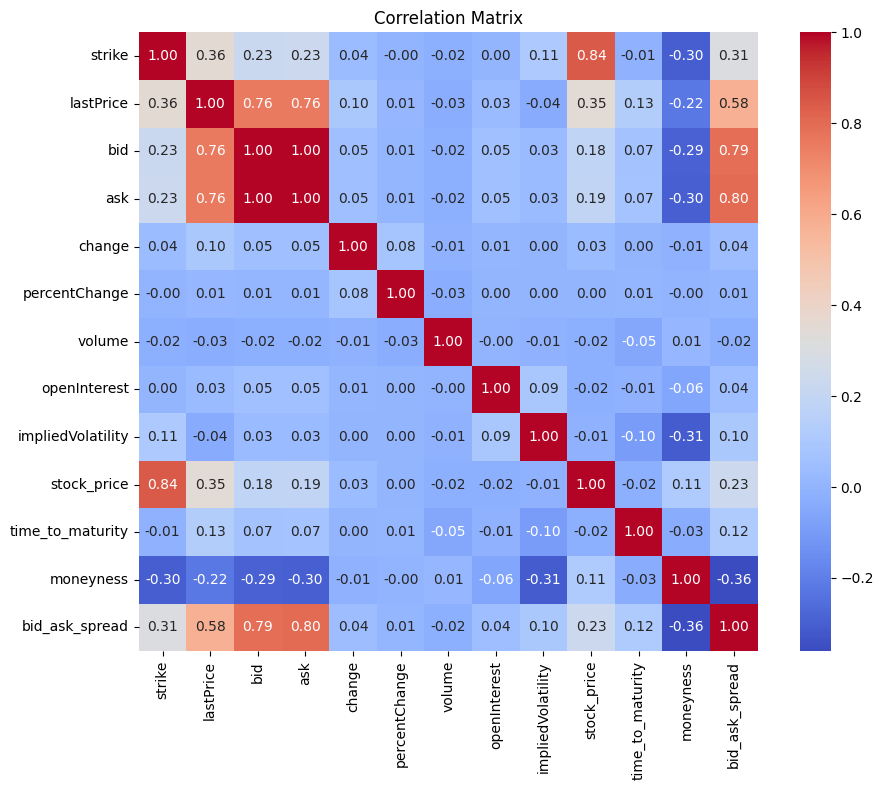

Correlation Matrix
                     strike  lastPrice       bid       ask    change  \
strike             1.000000   0.356566  0.227420  0.230203  0.036671   
lastPrice          0.356566   1.000000  0.756436  0.755915  0.098890   
bid                0.227420   0.756436  1.000000  0.999911  0.051952   
ask                0.230203   0.755915  0.999911  1.000000  0.051876   
change             0.036671   0.098890  0.051952  0.051876  1.000000   
percentChange     -0.000751   0.011704  0.006585  0.006634  0.077548   
volume            -0.023938  -0.028484 -0.015882 -0.016055 -0.005663   
openInterest       0.002075   0.028215  0.053873  0.053906  0.007009   
impliedVolatility  0.105057  -0.037893  0.030067  0.031665  0.003233   
stock_price        0.842523   0.348509  0.184970  0.186817  0.034148   
time_to_maturity  -0.009719   0.131270  0.069410  0.070754  0.001400   
moneyness         -0.304432  -0.221621 -0.294411 -0.297171 -0.013210   
bid_ask_spread     0.308636   0.578612  0.792

In [ ]:
# Select only numeric columns
numeric_columns = [col for col in options_data.select_dtypes(include=['float64', 'int64']).columns]

# Compute the correlation matrix for the filtered numeric columns
correlation_matrix = options_data[numeric_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Print the correlation matrix
print("Correlation Matrix")
print(correlation_matrix)


1.6.2 Feature Selection via Variance Inflation Factor (VIF) Analysis

In [ ]:
# X feature set based on correlation and logical relationships
X = options_data[['strike', 'bid', 'stock_price', 'impliedVolatility',
                          'time_to_maturity', 'moneyness', 'bid_ask_spread']]

# Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             Feature        VIF
0             strike  11.086565
1                bid   2.887668
2        stock_price   9.871240
3  impliedVolatility   1.163938
4   time_to_maturity   1.184417
5          moneyness   2.930105
6     bid_ask_spread   3.244627


2.0 Data Splitting

In [ ]:
# Feature set based on VIF analysis
X = options_data[['bid', 'stock_price', 'impliedVolatility',
                  'time_to_maturity', 'moneyness', 'bid_ask_spread']]
y = options_data['lastPrice']

# Split data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Save the test set indices from options_data
test_indices = X_test.index

# Further split train+validation into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True
)  # 25% of train_val is validation

# Initialize and apply StandardScaler
scaler = StandardScaler()

# Fit on training data and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Compute Metrics on Test Set
def compute_metrics(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    explained_variance = explained_variance_score(actual, predicted)

    return {
        "Model": model_name,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "Mean Absolute Percentage Error (MAPE)": mape,
        "R-squared (R²)": r2,
        "Explained Variance Score": explained_variance
    }

# Print Metrics
def print_metrics(metrics_dict):
    print(f"\nMetrics for {metrics_dict['Model']} Model:")
    for key, value in metrics_dict.items():
        if isinstance(value, (float, int)) and abs(value) > 1e6:
            print(f"  {key}: {value:.4e}")  # Use scientific notation for large numbers
        elif value == np.inf or value == -np.inf:
            print(f"  {key}: Infinity")
        else:
            print(f"  {key}: {value}")

3.2 Machine Learning Models Training and Evaluation

In [ ]:
# Function to evaluate models
def evaluate_models(X_train, X_val, y_train, y_val):
    # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "Support Vector Regression (SVR)": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    }

    results = []

    # Train and evaluate each model
    for name, model in models.items():
        try:
            print(f"Training and evaluating: {name}")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)  # Use validation set for evaluation

            # Compute metrics using the provided compute_metrics function
            metrics = compute_metrics(y_val, y_pred, name)

            # Append metrics to results
            results.append(metrics)
        except Exception as e:
            print(f"Error evaluating {name}: {e}")
            results.append({"Model": name, "Error": str(e)})

    # Return results as a DataFrame
    return pd.DataFrame(results)

# Evaluate models on training and validation sets
results_val = evaluate_models(X_train, X_val, y_train, y_val)

# Display results
print("Validation Set Results:")
print(results_val)


Training and evaluating: Linear Regression
Training and evaluating: Ridge Regression
Training and evaluating: Random Forest
Training and evaluating: Gradient Boosting
Training and evaluating: Support Vector Regression (SVR)
Validation Set Results:
                             Model  Mean Squared Error (MSE)  \
0                Linear Regression              10525.431807   
1                 Ridge Regression              10525.430080   
2                    Random Forest                676.218183   
3                Gradient Boosting               3508.271399   
4  Support Vector Regression (SVR)              15093.463847   

   Root Mean Squared Error (RMSE)  Mean Absolute Error (MAE)  \
0                      102.593527                  48.816828   
1                      102.593519                  48.816829   
2                       26.004195                   7.587412   
3                       59.230663                  19.959248   
4                      122.855459              

3.3 Hyperparameter Tuning for the Best Performed Machine Learning Model

In [ ]:
# Define the parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Random Forest Tuning using RandomizedSearchCV
def tune_random_forest(X_train, y_train, param_distributions, n_iter=20, n_jobs=-1):
    rf = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=3,  # Cross-validation folds
        scoring='neg_mean_squared_error',  # Evaluation metric
        n_jobs=n_jobs,  # Parallel processing for speed
        random_state=42  # For reproducibility
    )
    random_search.fit(X_train, y_train)
    return random_search.best_params_, -random_search.best_score_

# Hyperparameter tuning
print("Starting Random Forest Hyperparameter Tuning...")
best_params, best_val_mse = tune_random_forest(X_train, y_train, param_distributions)

print(f"Best Parameters: {best_params}")
print(f"Best Validation MSE: {best_val_mse:.4f}")

Starting Random Forest Hyperparameter Tuning...
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Best Validation MSE: 996.4099


3.4 Machine Learning Model Retraining

In [ ]:
# Train Random Forest with Best Parameters
def train_final_rf(X_train, y_train, best_params):
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    return model

# Retrain final model using the entire training set (X_train includes all training data)
print("\nRetraining Final Random Forest Model...")
final_rf_model = train_final_rf(X_train, y_train, best_params)
print("Final model retrained using the best hyperparameters.")



Retraining Final Random Forest Model...
Final model retrained using the best hyperparameters.


3.5 Final Machine Learning Model Evaluation

In [ ]:
# Evaluate the model using compute_metrics function
def evaluate_final_model(model, X_test, y_test, model_name="Random Forest"):
    # Predict test set results
    y_test_pred = model.predict(X_test)

    # Compute metrics using the custom function
    metrics = compute_metrics(y_test, y_test_pred, model_name)

    # Print the metrics in a structured format
    print(f"\nEvaluation Metrics for {metrics['Model']} Model on Test Set:")
    for key, value in metrics.items():
        if key != "Model":
            print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

    return metrics

# Perform evaluation
print("\nEvaluating Final Model on Test Set")
test_metrics = evaluate_final_model(final_rf_model, X_test, y_test)



Evaluating Final Model on Test Set

Evaluation Metrics for Random Forest Model on Test Set:
  Mean Squared Error (MSE): 1146.7076
  Root Mean Squared Error (RMSE): 33.8631
  Mean Absolute Error (MAE): 8.3755
  Mean Absolute Percentage Error (MAPE): 149.4269
  R-squared (R²): 0.9566
  Explained Variance Score: 0.9566


3.6.1 Pricing Result from Random Forest vs Actual Prices

In [ ]:
# Calculate prediction errors
rf_predictions = final_rf_model.predict(X_test)  # Predicted prices from Random Forest
prediction_errors = y_test - rf_predictions      # Residuals: Actual - Predicted

# Create a DataFrame with all results
pricing_results_complete = pd.DataFrame({
    "Actual Prices": y_test.values,       # Actual market prices (lastPrice)
    "Predicted Prices": rf_predictions,  # Predicted prices by Random Forest
    "Residuals (Actual - Predicted)": prediction_errors
})

# Display the entire DataFrame
print("Complete Pricing Results:")
print(pricing_results_complete)

# Save the complete pricing results to a CSV file
pricing_results_complete.to_csv("complete_pricing_results_rf.csv", index=False)

# Download the file directly
files.download("complete_pricing_results_rf.csv")
print("Complete pricing results saved to 'complete_pricing_results_rf.csv'.")


Complete Pricing Results:
       Actual Prices  Predicted Prices  Residuals (Actual - Predicted)
35166         186.75        188.149430                       -1.399430
9670            1.26          1.145240                        0.114760
69301         361.83        298.652682                       63.177318
39166           8.75         12.889852                       -4.139852
75907         210.52        197.048494                       13.471506
...              ...               ...                             ...
76415           0.04          0.046582                       -0.006582
9420           40.70         38.495648                        2.204352
66193           0.03          0.193065                       -0.163065
56482         345.90        292.602164                       53.297836
53168           5.00          5.308689                       -0.308689

[14899 rows x 3 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Complete pricing results saved to 'complete_pricing_results_rf.csv'.


3.6.2 Scatter Plot for Random Forest based on Actual Prices

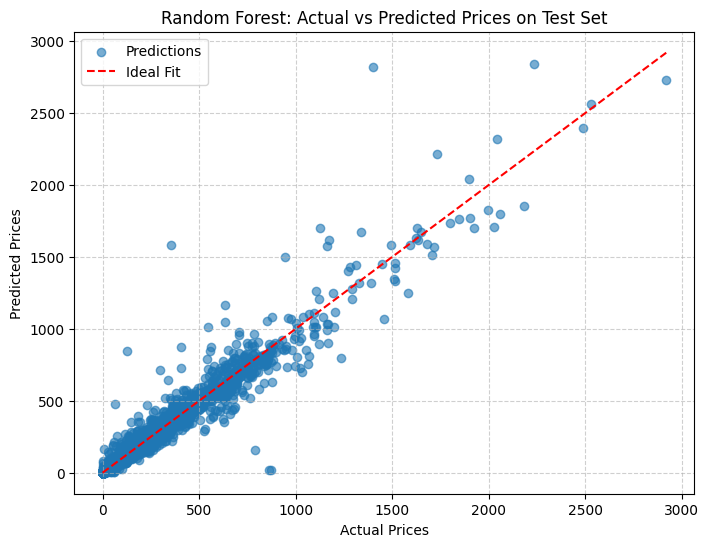

In [ ]:
y_test_pred = final_rf_model.predict(X_test)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, label="Predictions")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    label="Ideal Fit"
)  # Ideal line (perfect predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest: Actual vs Predicted Prices on Test Set")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


3.6.3 Histogram of Prediction Errors from Random Forest

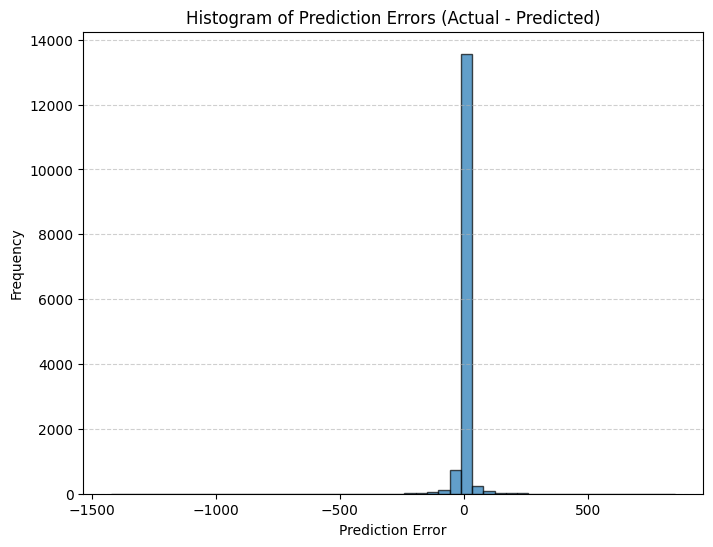

In [ ]:
# Calculate prediction errors
prediction_errors = y_test - y_test_pred

# Plot the histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(prediction_errors, bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Prediction Errors (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


3.6.4 Histogram of Actual vs Predicted Prices from Random Forest

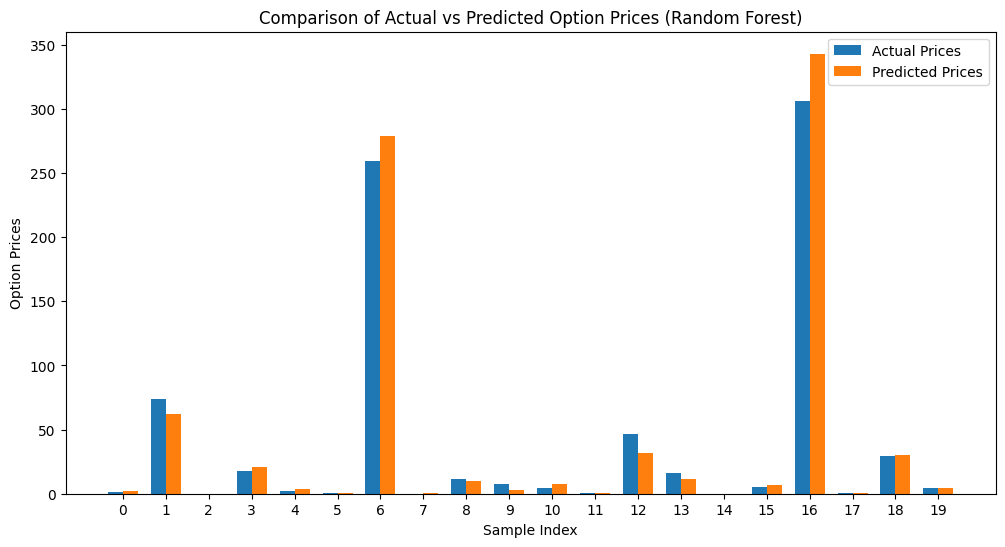

In [ ]:
# Sample data for visualization
sample_indices = np.random.choice(range(len(y_test)), size=20, replace=False)
sample_actual = y_test.iloc[sample_indices]
sample_predicted = y_test_pred[sample_indices]

# Create a bar plot for comparison
bar_width = 0.35
indices = np.arange(len(sample_indices))

plt.figure(figsize=(12, 6))
plt.bar(indices, sample_actual, bar_width, label="Actual Prices")
plt.bar(indices + bar_width, sample_predicted, bar_width, label="Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Option Prices")
plt.title("Comparison of Actual vs Predicted Option Prices (Random Forest)")
plt.xticks(indices + bar_width / 2, indices)
plt.legend()
plt.show()


3.6.5 Residual Plot of Predicted Prices vs Residuals

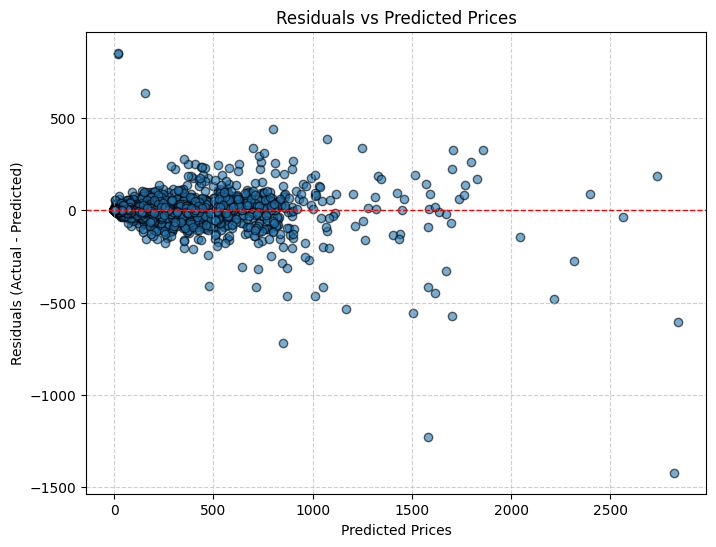

In [ ]:
# Plot residuals vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, prediction_errors, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs Predicted Prices")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


3.6.6 Error Summary

In [ ]:
# Calculate errors
rf_predictions = final_rf_model.predict(X_test)
rf_errors = y_test - rf_predictions

# Calculate Mean and Standard Deviation of Errors
error_summary = pd.DataFrame({
    "Model": ["Random Forest"],
    "Mean Error": [rf_errors.mean()],
    "Std Deviation of Error": [rf_errors.std()]
})

print("\nError Summary:")
print(error_summary)


Error Summary:
           Model  Mean Error  Std Deviation of Error
0  Random Forest   -0.125305               33.863976


3.7 Feature Importance of Random Forest for Model Intepretability

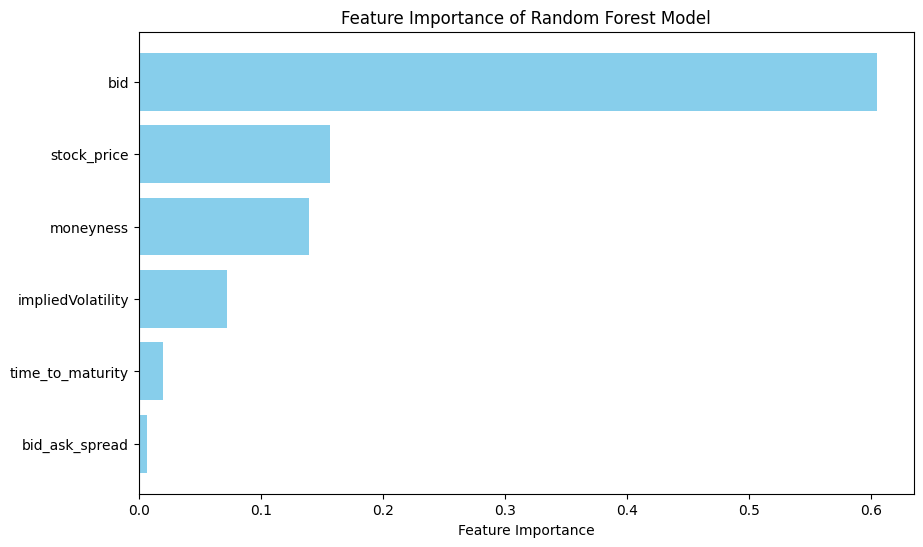

In [ ]:
# Get feature importances from the final trained model
feature_importance = final_rf_model.feature_importances_
features = X.columns  # Assuming X is a pandas DataFrame

# Sort the features by importance
sorted_idx = np.argsort(feature_importance)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], feature_importance[sorted_idx], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Random Forest Model")
plt.show()
